In [5]:
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

class TrafficQuantumClusterSystem:
    def __init__(self):
        self.scaler = StandardScaler()
        self.qmeans_centroids = None
        self.cluster_profiles = None
        self.dev = qml.device('default.qubit', wires=4, shots=2000)
        
        # Definizione del quantum circuit come parte dell'inizializzazione
        @qml.qnode(self.dev)
        def quantum_distance(point, center):
            qml.Hadamard(wires=0)
            qml.Hadamard(wires=1)
            qml.Hadamard(wires=2)
            qml.Hadamard(wires=3)
            
            qml.U3(point[0], point[1], np.pi, wires=1)
            qml.U3(center[0], center[1], np.pi, wires=2)
            
            qml.U3(point[2], 0, np.pi, wires=3)
            qml.U3(center[2], 0, np.pi, wires=3)
            
            qml.CSWAP(wires=[0, 1, 2])
            qml.Hadamard(wires=0)
            
            return qml.sample(qml.PauliZ(0))
        
        self.quantum_distance_circuit = quantum_distance
        
    def encode_points(self, point):
        a = (point[0] + 1) * np.pi / 2
        b = (point[1] + 1) * np.pi / 2
        c = (point[2] + 1) * np.pi / 2
        return (a, b, c)

    def calculate_distance(self, point, center):
        result = self.quantum_distance_circuit(point, center)
        return np.sum(result == -1)
        
    def quantum_kmeans(self, data, k=2, max_iter=100, tolerance=0.01):
        n_samples = len(data)
        w_new = data[np.random.choice(n_samples, k, replace=False)]
        
        error = 1
        iteration = 0
        clusters = np.zeros(n_samples)
        
        while error > tolerance and iteration < max_iter:
            w_old = deepcopy(w_new)
            
            for i in range(n_samples):
                min_dist = float('inf')
                point = self.encode_points(data[i])
                
                for j in range(k):
                    center = self.encode_points(w_old[j])
                    dist = self.calculate_distance(point, center)
                    
                    if dist < min_dist:
                        min_dist = dist
                        clusters[i] = j

            for i in range(k):
                if np.sum(clusters == i) > 0:
                    w_new[i] = np.mean(data[clusters == i], axis=0)
            
            error = np.linalg.norm(w_new - w_old)
            iteration += 1
            
            print(f"Iterazione {iteration}, Error: {error}")
        
        return w_new, clusters
    
    def fit(self, df):
        """
        Addestra il sistema di clustering sui dati storici con due cluster
        """
        # Prepara le feature
        df = self._prepare_features(df)
        
        # Standardizzazione
        X_scaled = self.scaler.fit_transform(df)
        
        # 1. Clustering binario quantistico
        print("Avvio clustering quantistico...")
        print(X_scaled.shape)
        self.qmeans_centroids, clusters = self.quantum_kmeans(X_scaled, k=2)
        
        # 2. Analisi dei cluster per identificare quello critico
        self.cluster_profiles = self._analyze_clusters(df, clusters)
        
        return self
    
    def _prepare_features(self, df):
        """
        Prepara le feature per l'analisi
        """
        features = [
            'value',
            'rain_1h',
            'wind_speed',
        ]
        
        return df[features]

    def _analyze_clusters(self, df, clusters):
        df_with_clusters = df.copy()
        df_with_clusters['cluster'] = clusters
        
        profiles = df_with_clusters.groupby('cluster').agg({
            'value': ['mean'],
        })
        
        # Il cluster critico è quello con il valore medio più alto
        critical_cluster = profiles[('value', 'mean')].idxmax()
        
        return {
            'profiles': profiles,
            'critical_cluster': critical_cluster
        }
    
    def check_cluster(self, current_data):
        """
        Verifica il cluster e determina se è in stato di allerta usando Q-means
        """
        # Prepara i dati correnti
        current_df = self._prepare_features(current_data)
        
        # Standardizzazione
        current_scaled = self.scaler.transform(current_df)
        
        # Determina il cluster usando quantum distance
        min_dist = float('inf')
        cluster = 0
        point = self.encode_points(current_scaled[0])
        
        for i, center in enumerate(self.qmeans_centroids):
            center_encoded = self.encode_points(center)
            dist = self.calculate_distance(point, center_encoded)
            if dist < min_dist:
                min_dist = dist
                cluster = i
        
        is_critical_cluster = (cluster == self.cluster_profiles['critical_cluster'])
        
        # Determina il livello di allerta
        if is_critical_cluster:
            alarm_level = 'ALLERTA'
            reasons = ['Condizioni di traffico critiche rilevate (Q-means)']
        else:
            alarm_level = 'NORMALE'
            reasons = ['Condizioni di traffico nella norma (Q-means)']
        
        return {
            'alarm_level': alarm_level,
            'reasons': reasons,
            'details': {
                'current_value': current_df['value'].iloc[0],
                'rain_1h': current_df['rain_1h'].iloc[0],
                'wind_speed': current_df['wind_speed'].iloc[0],
                'cluster': cluster,
                'is_critical_cluster': is_critical_cluster
            }
        }

Caricamento dei dati...

Valori mancanti nel dataset:
datetime         0
ts_get         781
value            0
areaAnalisi      0
id             781
hum            781
pres           781
rain_1h        781
wind_speed     781
wind_deg       781
clouds_all     781
max_temp       781
min_temp       781
ave_temp       781
cod_weather    781
dtype: int64
Righe dopo la rimozione dei valori mancanti: 5835

Addestramento del sistema quantistico...
Avvio clustering quantistico...
(5835, 3)
Iterazione 1, Error: 0.9780010016908773
Iterazione 2, Error: 0.06898648996564205
Iterazione 3, Error: 0.03805911043788115
Iterazione 4, Error: 0.01521722296747981
Iterazione 5, Error: 0.012119994465377423
Iterazione 6, Error: 0.005598016472537351

Caratteristiche dei cluster:

Cluster Profiles:
                value
                 mean
cluster              
0.0      24949.162530
1.0      30643.827107

Cluster critico: 1.0

Analisi del dataset completo...

Creazione visualizzazioni...


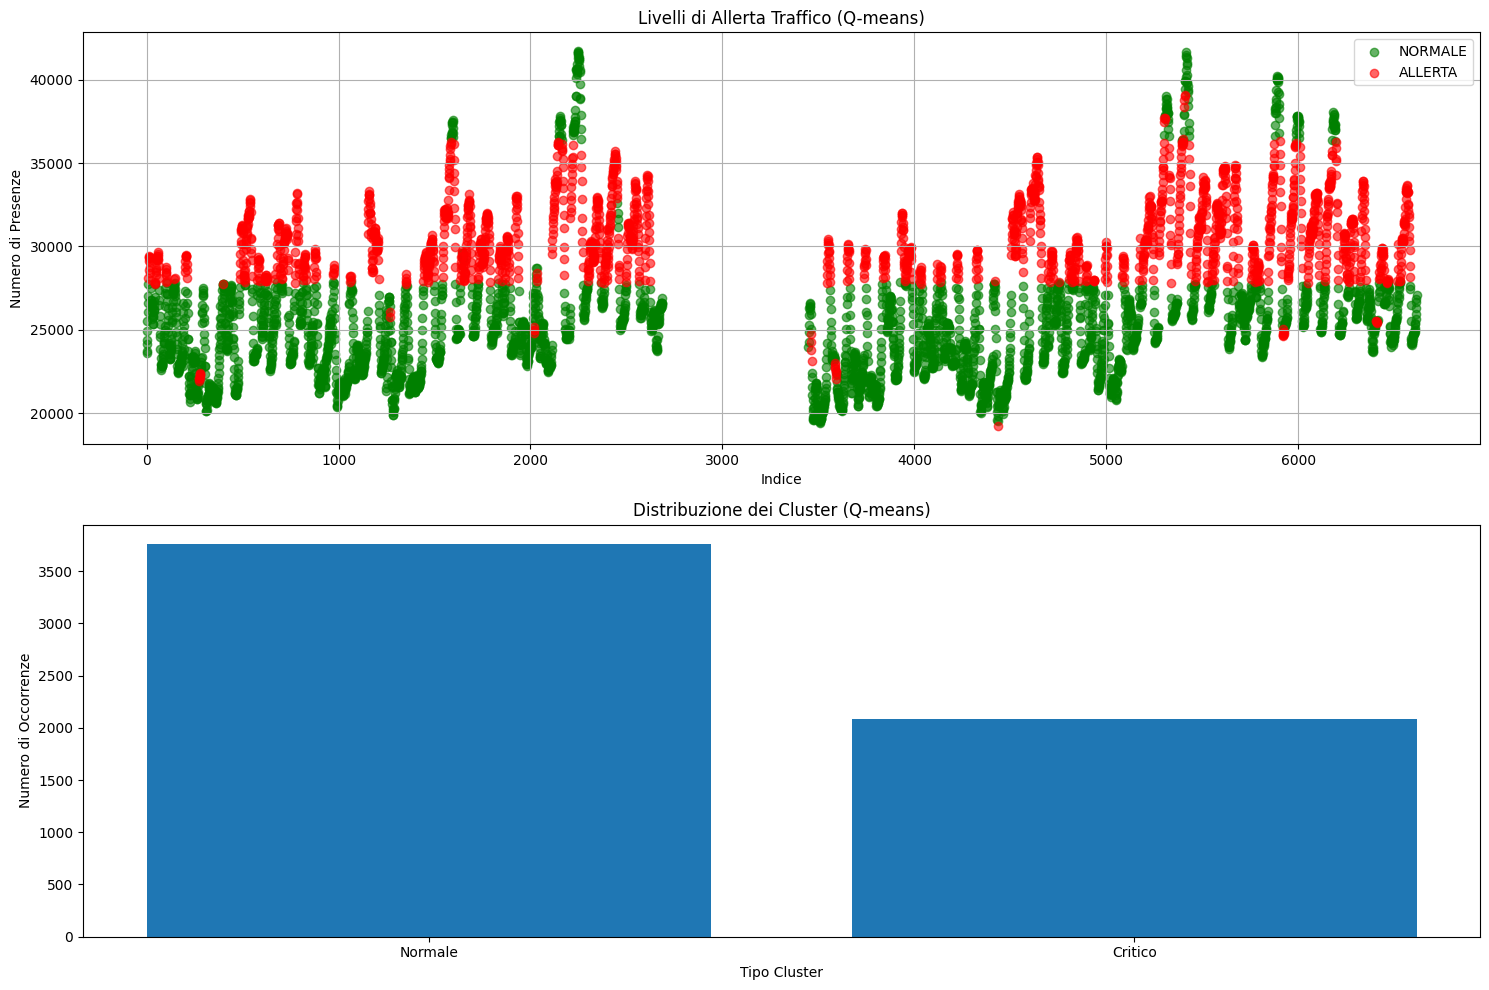


Riepilogo Allerte:
alarm_level
NORMALE    3755
ALLERTA    2080
Name: count, dtype: int64

Dettaglio situazioni di allerta:
      index            value alarm_level   
10       10  28077 (ALLERTA)     ALLERTA  \
11       11  28600 (ALLERTA)     ALLERTA   
12       12  29138 (ALLERTA)     ALLERTA   
13       13  29330 (ALLERTA)     ALLERTA   
14       14  29406 (ALLERTA)     ALLERTA   
...     ...              ...         ...   
5796   6577  30618 (ALLERTA)     ALLERTA   
5797   6578  30317 (ALLERTA)     ALLERTA   
5798   6579  29773 (ALLERTA)     ALLERTA   
5799   6580  28846 (ALLERTA)     ALLERTA   
5800   6581  28176 (ALLERTA)     ALLERTA   

                                                reasons  
10    Condizioni di traffico critiche rilevate (Q-me...  
11    Condizioni di traffico critiche rilevate (Q-me...  
12    Condizioni di traffico critiche rilevate (Q-me...  
13    Condizioni di traffico critiche rilevate (Q-me...  
14    Condizioni di traffico critiche rilevate (Q-me...  

In [6]:
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

# Caricamento dei dati
print("Caricamento dei dati...")
df = pd.read_csv('dataset_output/df1.csv')

print("\nValori mancanti nel dataset:")
print(df.isnull().sum())
df = df.dropna()
print("Righe dopo la rimozione dei valori mancanti:", len(df))

# Addestramento del sistema quantistico su tutto il dataset
print("\nAddestramento del sistema quantistico...")
quantum_system = TrafficQuantumClusterSystem()
quantum_system.fit(df)

print("\nCaratteristiche dei cluster:")
print("\nCluster Profiles:")
print(quantum_system.cluster_profiles['profiles'])
print(f"\nCluster critico: {quantum_system.cluster_profiles['critical_cluster']}")

print("\nAnalisi del dataset completo...")
results = []
for idx, row in df.iterrows():
    current_point = pd.DataFrame([row])
    result = quantum_system.check_cluster(current_point)
    results.append({
        'index': idx,
        'value': f"{row['value']} {'(ALLERTA)' if result['alarm_level'] == 'ALLERTA' else '(NORMALE)'}",
        'rain_1h': f"{row['rain_1h']} {'(ALLERTA)' if result['alarm_level'] == 'ALLERTA' else '(NORMALE)'}",
        'wind_speed': f"{row['wind_speed']} {'(ALLERTA)' if result['alarm_level'] == 'ALLERTA' else '(NORMALE)'}",
        'alarm_level': result['alarm_level'],
        'reasons': ' | '.join(result['reasons']),
        'cluster': result['details']['cluster']
    })

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame(results)

print("\nCreazione visualizzazioni...")
plt.figure(figsize=(15, 10))

# Plot 1: Trend del traffico con livelli di allerta
plt.subplot(2, 1, 1)
colors = {'NORMALE': 'green', 'ALLERTA': 'red'}
for level in colors:
    mask = results_df['alarm_level'] == level
    values = results_df[mask]['value'].apply(lambda x: float(x.split()[0]))
    plt.scatter(results_df[mask]['index'], 
               values,
               c=colors[level],
               label=level,
               alpha=0.6)

plt.title('Livelli di Allerta Traffico (Q-means)')
plt.xlabel('Indice')
plt.ylabel('Numero di Presenze')
plt.legend()
plt.grid(True)

# Plot 2: Distribuzione dei cluster
plt.subplot(2, 1, 2)
cluster_counts = results_df['cluster'].value_counts()
plt.bar(['Normale' if i != quantum_system.cluster_profiles['critical_cluster'] else 'Critico' 
         for i in cluster_counts.index], 
        cluster_counts.values)
plt.title('Distribuzione dei Cluster (Q-means)')
plt.xlabel('Tipo Cluster')
plt.ylabel('Numero di Occorrenze')

plt.tight_layout()
plt.show()

print("\nRiepilogo Allerte:")
print(results_df['alarm_level'].value_counts())

print("\nDettaglio situazioni di allerta:")
alert_situations = results_df[results_df['alarm_level'] == 'ALLERTA']
if not alert_situations.empty:
    print(alert_situations[['index', 'value', 'alarm_level', 'reasons']])
else:
    print("Nessuna situazione di allerta rilevata")

# Salva i risultati su file
results_df.to_csv('risultati_quantum_cluster.csv', index=False)
print("\nRisultati salvati in 'risultati_quantum_cluster.csv'")


In [7]:
from scipy.stats import pearsonr, f_oneway

def analyze_cluster_correlations(df, results_df, critical_cluster):
    """
    Analizza le correlazioni tra le variabili e il cluster critico.
    """
    # Creiamo un nuovo DataFrame che unisce i dati originali con le informazioni sui cluster
    merged_df = df.copy()
    merged_df['cluster'] = results_df['cluster']
    
    # Aggiungiamo una colonna "is_critical" per identificare se il dato appartiene al cluster critico
    merged_df['is_critical'] = (merged_df['cluster'] == critical_cluster).astype(int)
    
    # Analisi di correlazione (Pearson) tra le variabili originali e il fatto di essere nel cluster critico
    print("\nCorrelazione tra le variabili e l'appartenenza al cluster critico (Pearson):")
    for column in ['value', 'rain_1h', 'wind_speed']:
        corr, p_value = pearsonr(merged_df[column], merged_df['is_critical'])
        print(f"{column}: Correlazione = {corr:.4f}, P-value = {p_value:.4f}")
    
    # ANOVA per testare la significatività delle differenze tra i cluster
    print("\nAnalisi ANOVA per verificare se le variabili differiscono significativamente tra i cluster:")
    for column in ['value', 'rain_1h', 'wind_speed']:
        f_stat, p_value = f_oneway(merged_df[merged_df['cluster'] == 0][column],
                                   merged_df[merged_df['cluster'] == 1][column])
        print(f"{column}: F-stat = {f_stat:.4f}, P-value = {p_value:.4f}")

# Eseguiamo l'analisi
analyze_cluster_correlations(df, results_df, quantum_system.cluster_profiles['critical_cluster'])



Correlazione tra le variabili e l'appartenenza al cluster critico (Pearson):
value: Correlazione = 0.3451, P-value = 0.0000
rain_1h: Correlazione = 0.0104, P-value = 0.4279
wind_speed: Correlazione = 0.1905, P-value = 0.0000

Analisi ANOVA per verificare se le variabili differiscono significativamente tra i cluster:
value: F-stat = 1408.7268, P-value = 0.0000
rain_1h: F-stat = 6.4940, P-value = 0.0109
wind_speed: F-stat = 219.0487, P-value = 0.0000
